In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"

train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201231.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20210101_20210201.parquet"))

<AxesSubplot:>

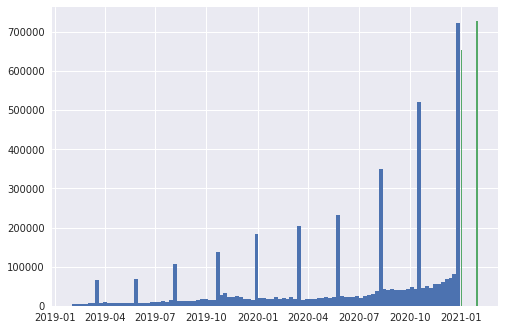

In [3]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=10)

In [4]:
# get fico baseline
# flip the sign to get positive corr with riskiness

def get_fico_adjusted_pred(df):
    
    df.loc[:, "fico_adjusted"] = (df["fico_score"] 
                                  * np.where(df["fico_score"] > 850, 0, 1))
    df.loc[:, "fico_adjusted_pred"] = -df["fico_adjusted"]
    
    return df

train_df = get_fico_adjusted_pred(train_df)
test_df = get_fico_adjusted_pred(test_df)

### Preprocess and get some stats
---

In [5]:
train_df = mu.preprocess(train_df)
test_df = mu.preprocess(test_df)

In [6]:
train_df.indeterminate.value_counts()

False    2918532
True     1738226
Name: indeterminate, dtype: int64

In [7]:
train_df.target.value_counts(normalize=True), test_df.target.value_counts(normalize=True)

(False    0.962759
 True     0.037241
 Name: target, dtype: float64,
 False    0.992724
 True     0.007276
 Name: target, dtype: float64)

In [8]:
train_df.indeterminate.value_counts(normalize=True), test_df.indeterminate.value_counts(normalize=True)

(False    0.62673
 True     0.37327
 Name: indeterminate, dtype: float64,
 True     0.806629
 False    0.193371
 Name: indeterminate, dtype: float64)

In [9]:
for d in test_df.sample_date.unique():
    print("===== date: ", d, " ======")
    print(test_df[test_df.sample_date==d][["target", "indeterminate"]].value_counts(normalize=True).sort_index())

===== date:  2021-01-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.190569
        True             0.801813
True    False            0.004325
        True             0.003293
dtype: float64
===== date:  2021-02-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.187898
        True             0.805133
True    False            0.004105
        True             0.002865
dtype: float64


We see much more indeterminates on Feb 1. What is the reason?

### TODO

### Fit Models
---

In our unfortunate naming: w_ind means with indeterminant that further translate to:
* We trained the model including the indeterminant data.

In [10]:
# with indeterminant
clf_w_ind = refit.train(train_df,
                  date_col="sample_date",
                  indeterminate_col=None)

modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    4483337
True      173421
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

In [11]:
# without indeterminant
clf_wo_ind = refit.train(train_df,
                  date_col="sample_date",
                  indeterminate_col="indeterminate")

data statistics (4656758, 42)
indeterminate removed! column name:  indeterminate
data statistics after removing indeterminate (2918532, 42)
modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    2786508
True      132024
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_t

In [12]:
clf_w_ind, clf_wo_ind

(LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=25.852330455942475, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=21.10607162334121, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1))

In [13]:
import pickle as pkl

with open("../../artifacts/20210508-reduced-features/customer_risk_w_ind.pkl", "wb") as f:
    pkl.dump(clf_w_ind, f)
    
with open("../../artifacts/20210508-reduced-features/customer_risk_wo_ind.pkl", "wb") as f:
    pkl.dump(clf_wo_ind, f)

In [14]:
import pickle as pkl

with open("../../artifacts/20210508-reduced-features/customer_risk_w_ind.pkl", "rb") as f:
    clf_w_ind = pkl.load(f)
    
with open("../../artifacts/20210508-reduced-features/customer_risk_wo_ind.pkl", "rb") as f:
    clf_wo_ind = pkl.load(f)

### Make Predictions, Scores, and RGs

In [15]:
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
prev_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [16]:
# let's scale by bads anyways
import rdsutils.score_alignment as sa

############################################
# the incumbent model and scaling method
############################################

test_df["pred_incumbent"] = prev_model.predict_proba(test_df[prev_model.feature_name_])[:,1]
test_df["score_incumbent"] = mu.scale_scores(test_df["pred_incumbent"])

#############################################
# prediction without indeterminates - dropped ind - rescaled
############################################

test_df["pred_wo_ind"] = clf_wo_ind.predict_proba(test_df[clf_wo_ind.feature_name_])[:,1]
test_df["score_wo_ind"] = mu.scale_scores(test_df["pred_wo_ind"])

#############################################
# prediction without indeterminates - dropped ind - rescaled
############################################

# test_df["pred_wo_ind"] = clf_wo_ind.predict_proba(test_df[clf_wo_ind.feature_name_])[:,1]  # pred

# # rescale
# src_pred = "pred_wo_ind"
# tgt_pred = "pred_incumbent"
# target_col = "target"
# br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
#                                    br_precision = 3, pred_precision = 3)
# test_df[src_pred + "_rescaled"] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
#                                                     pred_precision=3)

# # score
# test_df["score_wo_ind_rescaled"] = mu.scale_scores(test_df["pred_wo_ind_rescaled"])


############################################
# prediction with indeterminates
############################################

test_df["pred_w_ind"] = clf_w_ind.predict_proba(test_df[clf_w_ind.feature_name_])[:,1]

src_pred = "pred_w_ind"
tgt_pred = "pred_incumbent"
target_col = "target"

br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
                                   br_precision = 3, pred_precision = 3)
test_df[src_pred + "_rescaled"] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
                                                    pred_precision=3)

test_df["score_w_ind_rescaled"] = mu.scale_scores(test_df["pred_w_ind_rescaled"])


source column:  pred_w_ind
target columns:  pred_incumbent


In [17]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])


In [18]:
test_df['rg_incumbent'] = get_risk_groups(test_df.score_incumbent)
test_df['rg_wo_ind'] = get_risk_groups(test_df.score_wo_ind)
# test_df['rg_wo_ind_rescaled'] = get_risk_groups(test_df.score_wo_ind_rescaled)
test_df['rg_w_ind_rescaled'] = get_risk_groups(test_df.score_w_ind_rescaled)

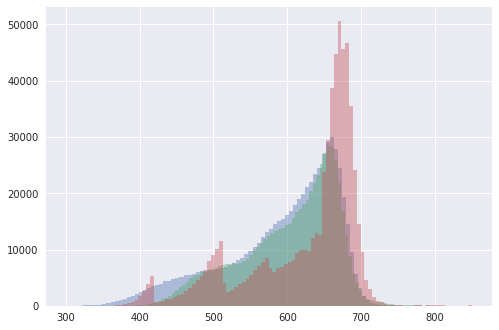

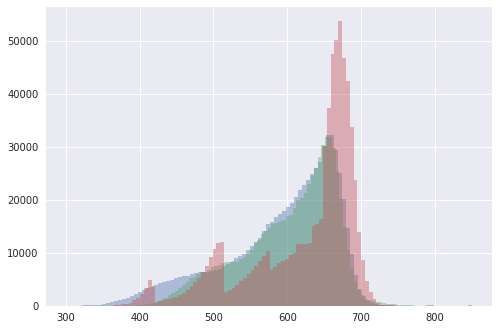

In [19]:
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff

for d in test_df.sample_date.unique():
    df_ = test_df[test_df.sample_date == d]
    for col in ["score_incumbent", "score_wo_ind", "score_w_ind_rescaled"]:
        df_[col].hist(bins=100, alpha=0.4, label=col)
    plt.show()

In [20]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)

In [21]:
train_df.to_parquet(os.path.join(s3_base_path, "dev_train_scored.parquet"))
test_df.to_parquet(os.path.join(s3_base_path, "dev_test_scored.parquet"))

In [22]:
# cols = ["business_account_number", "sample_date", "borrower_id", 
#         "pred_incumbent", "score_incumbent", "rg_incumbent", 
#         "pred_wo_ind", "score_wo_ind", "rg_wo_ind"]

# display(test_df[cols].shape)
# display(test_df["sample_date"].unique())
# test_df[cols].to_parquet("../../artifacts/refitting-202021Q1/to_david.parquet")
# for d in test_df["sample_date"].unique():
#     dt_str = str(d).split("T")[0]
#     test_df[test_df["sample_date"] == d][cols].to_csv(f"../../artifacts/refitting-202021Q1/test_df_{dt_str}.csv", index=False)

### Performance
---

In [23]:
import src.monitoring.monitoring as mntr
import seaborn as sns

plt.style.use("seaborn")

def plot_score_distr(df, score1, score2, ax, title):
    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)

    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()
    
    
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

#### 2021-01-01

,auc,ap,ks
fico_adjusted_pred,64.93,1.16,25.72
fraud_score_2,67.48,1.91,27.52
score_incumbent,68.62,10.02,23.51
score_wo_ind,77.92,18.29,39.35


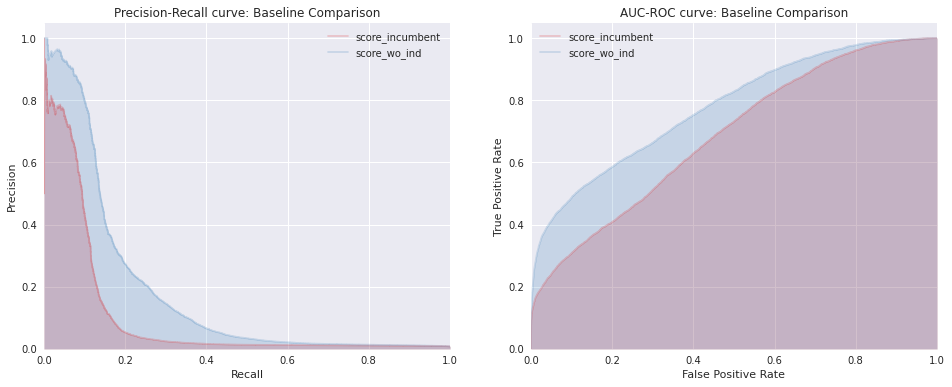

In [24]:
pred_cols = ['fico_adjusted_pred',
             'fraud_score_2',
             "score_incumbent", 
             "score_wo_ind"]
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]

report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)


pred_cols = ["score_incumbent", 
             "score_wo_ind"]

mntr_path = "./artifacts/refitting"
mntr.save_valid_performance_plots(
        {"2021-01-01": df_}, "target", pred_cols, mntr_path, dropna=False
    )


In [25]:
# model prediction
mntr.get_segmented_performances(
    {"2021-01-01": df_},
    "target",
    ["score_wo_ind"],
    os.path.join(mntr_path, "2021-01-01"),
    model_name="customer_risk",
)

# on vs fico adjusted - only valid fico
mntr.get_model_vs_baseline(
    df_,
    "target",
    "score_wo_ind",
    "score_incumbent",
    os.path.join(mntr_path, "2021-01-01"),
)


ratio of users kept their RG:  0.7169143568543423


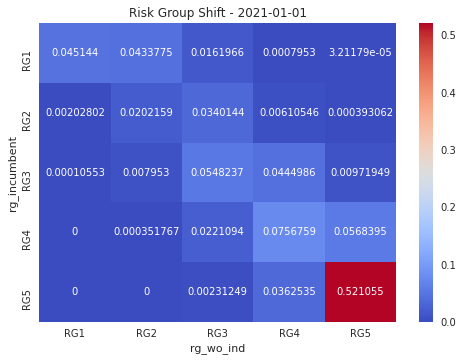

In [26]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_wo_ind"
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - 2021-01-01')

fig.savefig(os.path.join(mntr_path, "rg_shift_2021-01-01.png"))
print("ratio of users kept their RG: ", np.trace(table))

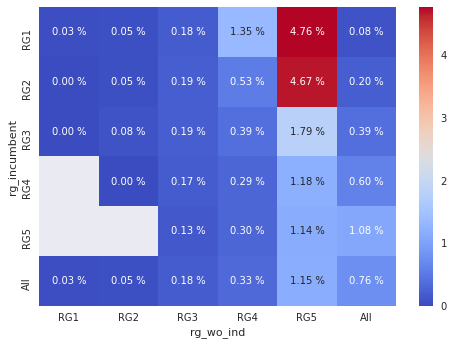

In [27]:
import rdsutils.swap_set_analysis as ssa
fig, ax = ssa.plot_swap_set_bad_rate(df_, rg_incumbent, rg_refit, "target", margins=True)
fig.savefig(os.path.join(mntr_path, "bad_rate-2021-01-01.png"))

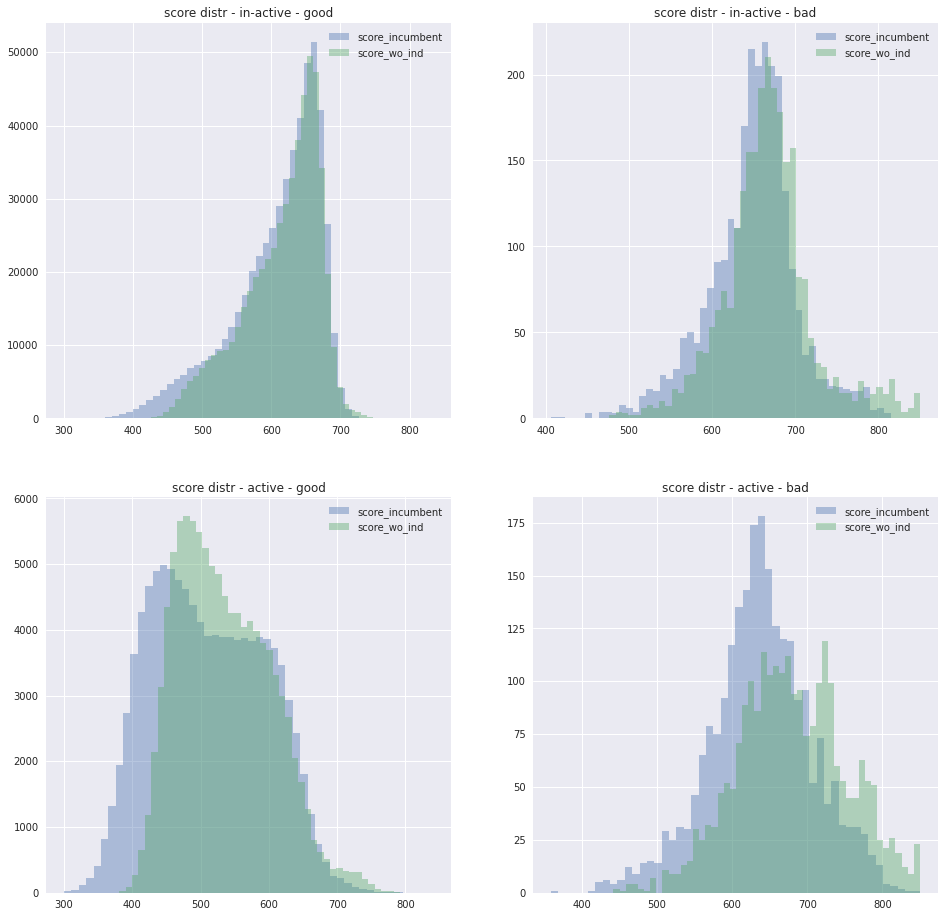

In [28]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_wo_ind"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]

df__ = df_[~df_.is_active & ~df_.target]  # inactive good accounts
plot_score_distr(df__, score1, score2, axs[0, 0], "score distr - in-active - good")

df__ = df_[~df_.is_active & df_.target]  # inactive bad accounts
plot_score_distr(df__, score1, score2, axs[0, 1], "score distr - in-active - bad")

df__ = df_[df_.is_active & ~df_.target]  # active good accounts
plot_score_distr(df__, score1, score2, axs[1, 0], "score distr - active - good")

df__ = df_[df_.is_active & df_.target]  # active bad accounts
plot_score_distr(df__, score1, score2, axs[1, 1], "score distr - active - bad")

plt.show()
fig.savefig(os.path.join(mntr_path, "2021-01-01_activeness.png"))

#### 2021-02-01

,auc,ap,ks
fico_adjusted_pred,64.41,1.04,24.64
fraud_score_2,67.45,1.78,27.13
score_incumbent,67.33,10.30,21.94
score_wo_ind,75.75,16.25,36.42


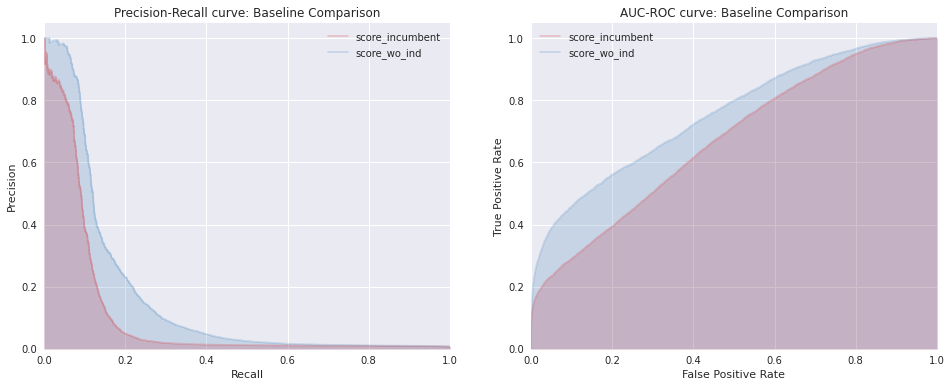

In [29]:
pred_cols = ['fico_adjusted_pred',
             'fraud_score_2',
             "score_incumbent", 
             "score_wo_ind"]

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-02-01")]

report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

pred_cols = ["score_incumbent", 
             "score_wo_ind"]

mntr_path = "./artifacts/refitting"
mntr.save_valid_performance_plots(
        {"2021-02-01": df_}, "target", pred_cols, mntr_path, dropna=False
    )

In [30]:
# model prediction
mntr.get_segmented_performances(
    {"2021-02-01": df_},
    "target",
    ["score_wo_ind"],
    os.path.join(mntr_path, "2021-02-01"),
    model_name="customer_risk",
)

# on vs fico adjusted - only valid fico
mntr.get_model_vs_baseline(
    df_,
    "target",
    "score_wo_ind",
    "score_incumbent",
    os.path.join(mntr_path, "2021-02-01"),
)


ratio of users kept their RG:  0.7134781724101904


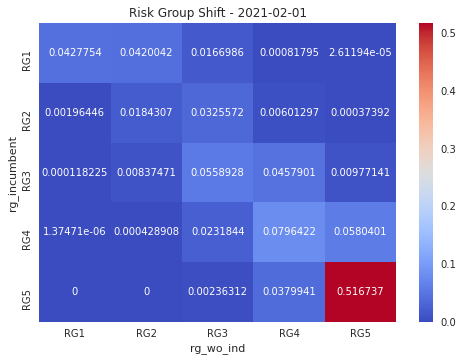

In [31]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_wo_ind"
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - 2021-02-01')

fig.savefig(os.path.join(mntr_path, "rg_shift_2021-02-01.png"))
print("ratio of users kept their RG: ", np.trace(table))

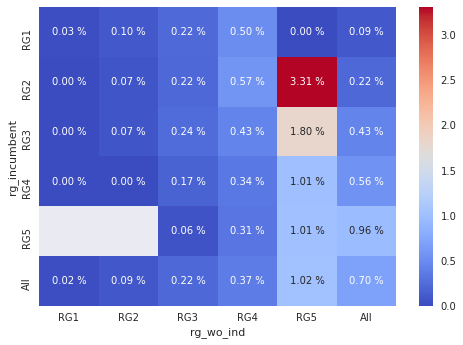

In [32]:
import rdsutils.swap_set_analysis as ssa
fig, ax = ssa.plot_swap_set_bad_rate(df_, rg_incumbent, rg_refit, "target", margins=True)
fig.savefig(os.path.join(mntr_path, "bad_rate-2021-02-01.png"))

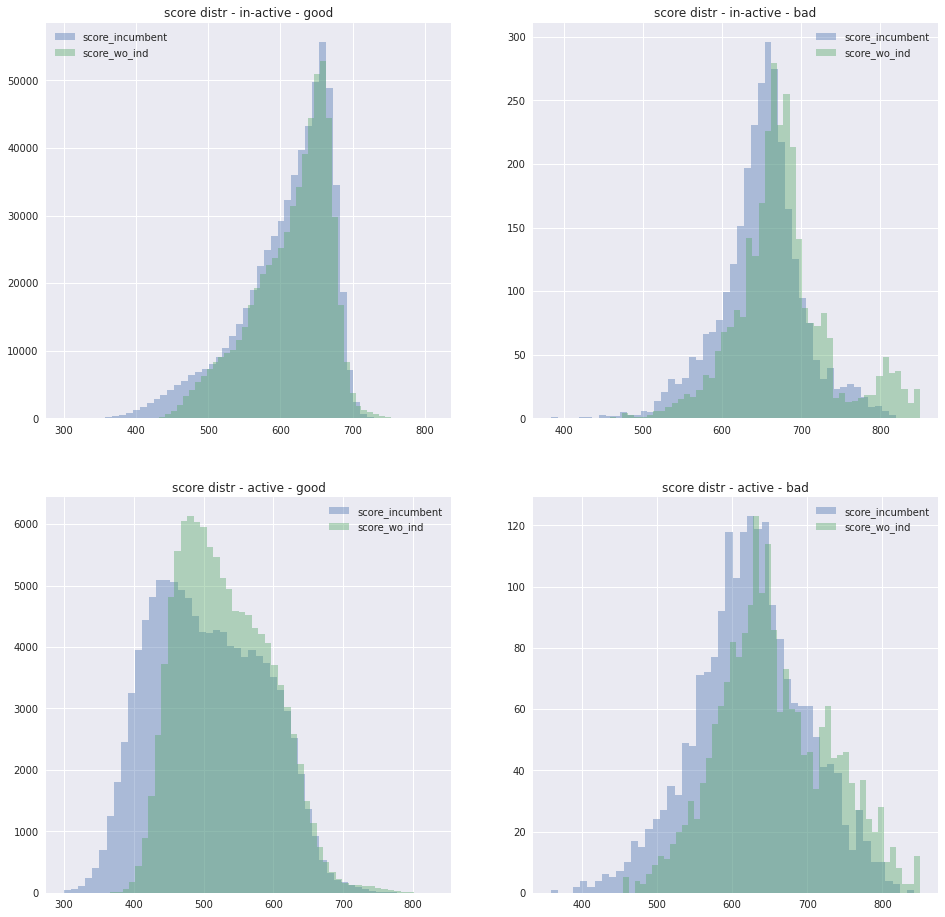

In [33]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_wo_ind"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-02-01")]

df__ = df_[~df_.is_active & ~df_.target]  # inactive good accounts
plot_score_distr(df__, score1, score2, axs[0, 0], "score distr - in-active - good")

df__ = df_[~df_.is_active & df_.target]  # inactive bad accounts
plot_score_distr(df__, score1, score2, axs[0, 1], "score distr - in-active - bad")

df__ = df_[df_.is_active & ~df_.target]  # active good accounts
plot_score_distr(df__, score1, score2, axs[1, 0], "score distr - active - good")

df__ = df_[df_.is_active & df_.target]  # active bad accounts
plot_score_distr(df__, score1, score2, axs[1, 1], "score distr - active - bad")

plt.show()
fig.savefig(os.path.join(mntr_path, "2021-02-01_activeness.png"))

#### Stats

In [34]:
test_df.sample_date.value_counts()

2021-02-01    727444
2021-01-01    653852
Name: sample_date, dtype: int64

In [35]:
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.598379
        True             0.364380
True    False            0.028351
        True             0.008890
dtype: float64

In [36]:
test_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.189162
        True             0.803561
True    False            0.004209
        True             0.003067
dtype: float64

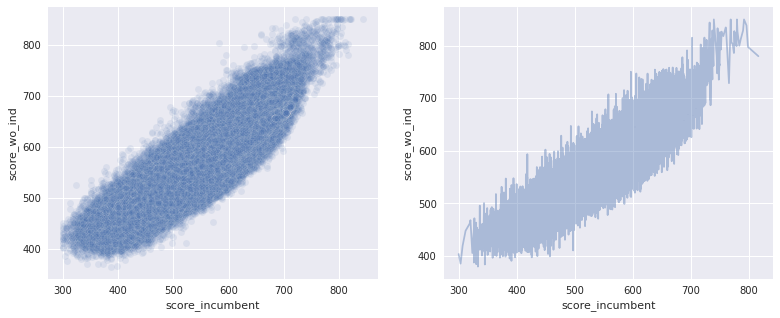

In [37]:
fig, axs = plt.subplots(1,2, figsize=(13, 5))
sns.scatterplot(x=df_.score_incumbent, 
                y=df_.score_wo_ind, 
                alpha=0.1,
                ax=axs[0])

idx = range(1, len(df_), 10)

sns.lineplot(data=df_.iloc[idx, :], x="score_incumbent", y="score_wo_ind", alpha=0.4, ax=axs[1])

plt.show()